Installing necessary prereqs: [NetworkX](https://networkx.org/documentation/stable/reference/index.html) for graphing, [PuLP](https://coin-or.github.io/pulp/main/index.html) for linear programming.

In [1]:
%pip install networkx pulp

Note: you may need to restart the kernel to use updated packages.


In [2]:

import json
import networkx as nx

file = open("map_ia.json")
data = json.load(file)

adjacencies = data["adj"]
countyNames = data["county"]
pop = data["pop"]

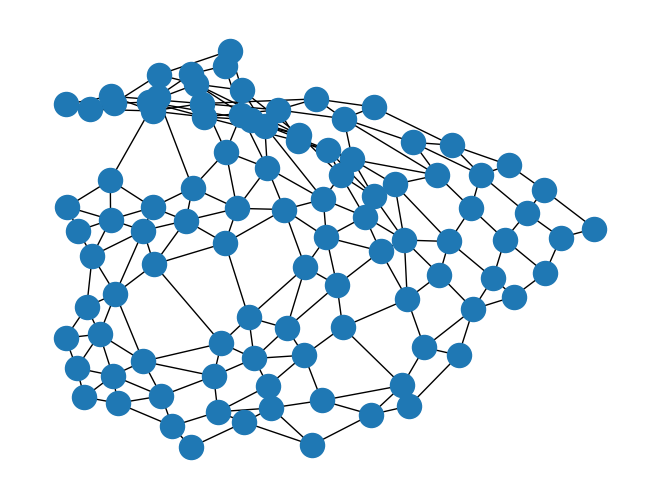

In [3]:
from random import Random

stateGraph = nx.Graph()

r =  Random(51535162)
totalPop = 0
# Add the nodes as necessary

for i in range(0, len(adjacencies)):
    # Adds node for each set of adjacencies
    stateGraph.add_node(countyNames[i], weight=pop[i])
    totalPop += pop[i]
    # Adds necessary edges; double-adding doesn't matter
    for j in adjacencies[i]:
        # Add edge with uniformly random weight 0, 10
        stateGraph.add_edge(countyNames[i], countyNames[j], weight=r.uniform(0, 10))

nx.draw(stateGraph)

In [4]:
# Number of districts
NUM_DISTRICTS = 4

# Population Tolerance
ALPHA = .10

# Population per district
targetPop = totalPop / NUM_DISTRICTS

# Binary indicators, defined as 1 if in node in same partitition as 
# source S or 0 in same as sink O. Initializes to 0.
V = [0 for i in range(stateGraph.order())]

# 
Y = [[0 for i in range(stateGraph.order())] for j in range(stateGraph.order())]


In [6]:
import pulp 

prog = pulp.LpProblem("CutPartition", pulp.LpMinimize)

# Defining Partition Binary
xVars = []
for n in stateGraph.nodes:
    var = pulp.LpVariable("x" + n, cat=pulp.LpBinary)
    xVars.append(var)
    prog += var
# Defining crossing binary
edgeVars = []
weights = []
for n, m in stateGraph.edges:
    var = pulp.LpVariable("y" + n + m, cat=pulp.LpBinary)
    edgeVars.append(var)
    weights.append(stateGraph[n][m]['weight'])
    prog += var
# Subset sum
popVariables = []
for i in range(len(xVars)):
    popVariables.append(pulp.LpAffineExpression(xVars[i] * pop[i]))
# Max Pop
prog += pulp.lpSum(popVariables) <= targetPop * (1 + ALPHA)
# Min Pop
prog += pulp.lpSum(popVariables) >= targetPop * (1 - ALPHA)

# Define Minimization Target
# Edgeweights
edgeWeightVars = []
for i in range(len(edgeVars)):
    edgeWeightVars.append(pulp.LpAffineExpression(edgeVars[i] * weights[i]))
prog += pulp.LpAffineExpression(pulp.lpSum(edgeWeightVars), name="Z")


prog.solve()


for var in xVars:
    print(var.value())

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/eaf90d27cc674d9da70e6a33e9eaae3e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/eaf90d27cc674d9da70e6a33e9eaae3e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 1070 RHS
At line 1073 BOUNDS
At line 1395 ENDATA
Problem MODEL has 2 rows, 321 columns and 198 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 1 rows, 99 columns (99 integer (99 of which binary)) and 99 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.135745
Cbc0038I Solution found of 0
Cbc0038I Before mini branch and bound, 98 int